<a href="https://colab.research.google.com/github/SUSREE64/ColabNotebooks/blob/main/NLP_Learning_with_NLTK_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NLP Tutorial with NLTK

In [184]:
# Here we are importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [185]:
import nltk
import string
import re
import seaborn as sns
from nltk import word_tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [186]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [187]:
## from sklearn import metrics for getting accuracy and other metrics for the model
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, roc_auc_score, confusion_matrix, roc_curve

### Connecting to Google Drive to get the data

In [5]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [188]:
file_path ="/content/gdrive/My Drive/Colab Notebooks/TwitterData/"
file_name = "train.csv"
file = file_path+file_name
train_df = pd.read_csv(file)
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [189]:
file_path ="/content/gdrive/My Drive/Colab Notebooks/TwitterData/"
file_name = "test.csv"
file = file_path+file_name
test_df = pd.read_csv(file)
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


### Exploratory analysis on the data file  -- This section will be written later

In [190]:
#### Some Cleaning of data frame

In [191]:
# filling the missing values  with 'None'
train_df.fillna({'keyword': 'None', 'location': 'None'}, inplace=True)
train_df.head()

,id,keyword,location,text,target
0,1,None,None,Our Deeds are the Reason of this #earthquake M...,1
1,4,None,None,Forest fire near La Ronge Sask. Canada,1
2,5,None,None,All residents asked to 'shelter in place' are ...,1
3,6,None,None,"13,000 people receive #wildfires evacuation or...",1
4,7,None,None,Just got sent this photo from Ruby #Alaska as ...,1


In [192]:
#Rows and columns of the dataframe
train_df.shape

(7613, 5)

In [193]:
#Removing the missing value rows
train_df = train_df.drop_duplicates(['text'], keep = "last")
train_df.shape

(7503, 5)

### Text Clean up and pre processing for NLP

In [194]:
def preprocess_text(text):
  text_lwr = text.lower()
  #remove https ---
  remove_url = re.compile(r'https?://\S+|www\.\S+')
  remove_url = remove_url.sub(r'',text_lwr)
  #remove some special characters
  remove_html=re.compile(r'<.*?>')
  remove_html = remove_html.sub(r'',remove_url)
  remove_emoji = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
  remove_emoji = remove_emoji.sub(r'', remove_html)
  remove_punct=str.maketrans('','',string.punctuation)
  remove_punct = remove_emoji.translate(remove_punct)
  wordTokens = word_tokenize(remove_punct)
  #filtered = [w for w in wordTokens if not w in stop_words] 
  lemmatized_words = [lemmatizer.lemmatize(word) for word in wordTokens]
  
  cleaned = ' '.join(lemmatized_words)
    
  return cleaned


In [195]:
text = train_df['text'][2567]
text

'Me and all my friends could destroy this in 2hours lmao  https://t.co/waCtT18gdA'

In [196]:
clean_text = preprocess_text(text)
clean_text

'me and all my friend could destroy this in 2hours lmao'

In [197]:
train_df['clean_text'] = train_df['text'].astype('str').apply(preprocess_text)

In [198]:
train_df['clean_text'][0:10]

0    our deed are the reason of this earthquake may...
1                forest fire near la ronge sask canada
2    all resident asked to shelter in place are bei...
3    13000 people receive wildfire evacuation order...
4    just got sent this photo from ruby alaska a sm...
5    rockyfire update california hwy 20 closed in b...
6    flood disaster heavy rain cause flash flooding...
7    im on top of the hill and i can see a fire in ...
8    there an emergency evacuation happening now in...
9     im afraid that the tornado is coming to our area
Name: clean_text, dtype: object

### Model building

#### ['location', 'keyword' , 'text'] are the features. target is the hand classified label column. A modle needs to be built on features. Categorical columns are OneHotEncoded to numeric form before applying a model.

In [220]:
categorical_features = ['keyword', 'location']

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

text_to_vector_transformer = CountVectorizer()

preprocessor = ColumnTransformer(
    transformers = [ ('cat', categorical_transformer, categorical_features), ('text', text_to_vector_transformer, 'clean_text')])

### Building a classifier (first hot encoding ("preprocessor") and Logistic regression as a classifier

```
# This is formatted as code
```



In [221]:
clsfier = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', LogisticRegression(max_iter = 1000))])

In [222]:
### Separate features and label from the data set

In [223]:
X = train_df[['keyword','location','clean_text']]
y = train_df['target']

In [224]:
X.head(3)

,keyword,location,clean_text
0,None,None,our deed are the reason of this earthquake may...
1,None,None,forest fire near la ronge sask canada
2,None,None,all resident asked to shelter in place are bei...


In [225]:
y.head(3)

0    1
1    1
2    1
Name: target, dtype: int64

#### Directly going for predicting 

In [226]:
y_pred = cross_val_predict(clsfier, X, y, cv=3)

In [227]:
y_pred

array([1, 1, 1, ..., 0, 1, 1])

In [228]:
## from sklearn import metrics for getting accuracy and other metrics for the model
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, roc_auc_score, confusion_matrix, roc_curve

In [229]:
print( "accuracy", accuracy_score(y, y_pred))

accuracy 0.7123817139810742


In [230]:
print( "f1_score", f1_score(y, y_pred))

f1_score 0.6316148856264936


In [231]:
print("precision Score", precision_score(y, y_pred))

precision Score 0.6949661908339594


[[3495  812]
 [1346 1850]]


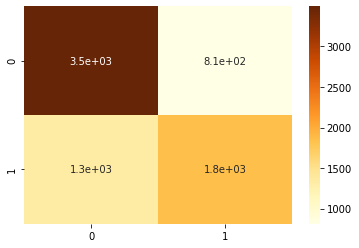

In [232]:
conf_matrix = confusion_matrix(y, y_pred)
print(conf_matrix)
p= sns.heatmap(annot=True, cmap='YlOrBr', data=conf_matrix)

### predicting the results on a test file 

In [233]:
test_df.fillna({'keyword': 'None', 'location': 'None'}, inplace=True)
test_df.head()

,keyword,location,clean_text
0,None,None,just happened a terrible car crash
1,None,None,heard about earthquake is different city stay ...
2,None,None,there is a forest fire at spot pond goose are ...
3,None,None,apocalypse lighting spokane wildfire
4,None,None,typhoon soudelor kill 28 in china and taiwan


In [234]:
test_df['clean_text'] = test_df['text'].astype('str').apply(preprocess_text)
test_df['clean_text'][0:10]

KeyError: ignored

In [235]:
test_df.head()

,keyword,location,clean_text
0,None,None,just happened a terrible car crash
1,None,None,heard about earthquake is different city stay ...
2,None,None,there is a forest fire at spot pond goose are ...
3,None,None,apocalypse lighting spokane wildfire
4,None,None,typhoon soudelor kill 28 in china and taiwan


In [215]:
test_df.drop(columns=['id','text'], inplace=True)
test_df.head()

,keyword,location,clean_text
0,None,None,just happened a terrible car crash
1,None,None,heard about earthquake is different city stay ...
2,None,None,there is a forest fire at spot pond goose are ...
3,None,None,apocalypse lighting spokane wildfire
4,None,None,typhoon soudelor kill 28 in china and taiwan


In [236]:
clsfier.fit(X, y)
result = clsfier.predict(test_df)

In [237]:
result[0:5]

array([1, 1, 1, 1, 1])

In [238]:
test_df['target'] = result
test_df.head()

,keyword,location,clean_text,target
0,None,None,just happened a terrible car crash,1
1,None,None,heard about earthquake is different city stay ...,1
2,None,None,there is a forest fire at spot pond goose are ...,1
3,None,None,apocalypse lighting spokane wildfire,1
4,None,None,typhoon soudelor kill 28 in china and taiwan,1


In [239]:
file_path ="/content/gdrive/My Drive/Colab Notebooks/TwitterData/"
file_name = "answer.csv"


test_df.to_csv(file_path+file_name)